In [1]:
import cProfile
cProfile.run('')
import time
from numba import jit,autojit
from pdb import set_trace as bp
from math import *
import numpy as np
import pandas as pd
import scipy.linalg as linalg
import scipy.optimize as opt
from Coordinates import allCoordinates
from Connectivity import Connectivity
import matplotlib.pyplot as plt
from sklearn.neighbors import KDTree

         2 function calls in 0.000 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 <string>:1(<module>)
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}




In [2]:
def cellNodes(alpha,d,shape):
    # shape = "TRIANGLE"
    # angle = 90
    # alpha = radians(angle)
    # d = 1
    if shape == 'HEXAGON':
        Coord = np.zeros((4,3))
        Coord[0,0] = 0; Coord[0,1] = 0; Coord[0,2] = 0
        Coord[1,0] = Coord[0,0]; Coord[1,1] = Coord[0,1]+d; Coord[1,2] = 0
        Coord[2,0] = Coord[1,0] + d*cos(alpha); Coord[2,1] = Coord[1,1] + d*sin(alpha); Coord[2,2] = 0
        Coord[3,0] = Coord[1,0] - d*cos(alpha); Coord[3,1] = Coord[1,1] + d*sin(alpha); Coord[3,2] = 0
        return Coord
        # print(Coord)
    elif shape == 'TRIANGLE':
        Coord = np.zeros((3,3))
        Coord[0,0] = 0; Coord[0,1] = 0; Coord[0,2] = 0
        Coord[1,0] = d; Coord[1,1] = 0; Coord[1,2] = 0
        Coord[2,0] = d*cos(alpha); Coord[2,1] = d*sin(alpha); Coord[2,2] = 0
        return Coord
        # print(Coord)
    else:
        coordinates = 'Shape Not Defined. Try Hexagon or Triangle'
        return

In [3]:
def allCoordinates(alpha,d,nx,ny,shape,BC,plot):
	"""
	shape = "HEXAGON"
	BC = 'yes'
	d = 1
	angle = 30
	alpha = radians(angle)
	unitcell = cellNodes(alpha,d,shape)
	xDirection = unitcell
	nx = np.arange(1,20)
	ny = np.arange(1,30)
	bp() # Break point for debugging
	"""
# 	bp()
	unitcell = cellNodes(alpha,d,shape)
	xDirection = unitcell
	if shape == "HEXAGON":
		for ii in range(0,len(nx)-1):
			xSweep = unitcell[0:4,:] + [nx[ii]*2*d*cos(alpha),0,0]
			xDirection = np.concatenate((xDirection,xSweep),axis=0)
		df = pd.DataFrame(xDirection) # Converts the array to a dataframe
		xDirection = df.drop_duplicates() # Checks for duplicates
		xDirection = df.drop_duplicates().values # Converts dataframe back to array
		xTop = xDirection[:,1] == (max(xDirection[:,1]))
		xt = xDirection[xTop,:] + [0,d,0]
		xDirection = np.concatenate((xDirection,xt),axis=0)
		yDirection = xDirection
		if len(ny) != 1:
	    		for ii in range(0,len(ny)-1):
	        		ySweep = xDirection[:,:] + [0,ny[ii]*2*d*(1+sin(alpha)),0]
	        		yDirection = np.concatenate((yDirection,ySweep),axis=0)
	    	else:
	        	yDirection = xDirection
		temp  = np.round(yDirection[:,1],4) == round(max(yDirection[:,1] \
										- d*(1+sin(alpha))),4)

		yTop = yDirection[temp,:] + [0,d*(1+2*sin(alpha)),0];
		yDirection = np.concatenate((yDirection,yTop),axis=0)

		del temp
		del yTop
		allCoordinates = yDirection
		del xDirection, yDirection

	##########################;
	# Making Periodic Lattice ;
	##########################;
		if BC=='no':
			temp = np.round(allCoordinates[:,1],4) == round(max(allCoordinates[:,1]),4)
			yTop = allCoordinates[temp,:] + [0,d,0]
			allCoordinates = np.concatenate((allCoordinates,yTop),axis=0)
			del temp
			temp = np.round(allCoordinates[:,1],4) == round(max(allCoordinates[:,1]),4)
			allCoordinates[temp,:] = [0, 0, 0]

	###########;
	# Triangle ;
	###########;
	if shape == "TRIANGLE":
		for ii in range(1,len(nx)-1):
			xSweep = unitcell[0:3,:] + [nx[ii]*d,0,0]
			xDirection = np.concatenate((xDirection,xSweep),axis=0)
		
		df = pd.DataFrame(xDirection) # Converts the array to a dataframe
		xDirection = df.drop_duplicates() # Checks for duplicates
		xDirection = df.drop_duplicates().values # Converts dataframe back to array
		allCoordinates = xDirection
		angle = degrees(alpha)
		
		if angle == 90:
			temp = np.round(allCoordinates[:,0],4) ==\
			 round(max(allCoordinates[:,0]),4)
			allCoordinates[temp,:] = [0, 0, 0]
		
		yDirection = xDirection
		
		for ii in range (1,len(ny)):
        		ySweep = xDirection[:,:] + [0,ny[ii]*2*d*sin(alpha),0];
        		yDirection = np.concatenate((yDirection,ySweep),axis=0)
    		temp = yDirection[:,1] == max(yDirection[:,1])
        	yDirection[temp,:] = [0, 0, 0]
    	
    		del temp
    	
    		allCoordinates = yDirection

    		del xDirection, yDirection

	####################;
	# # Drop Duplicates ;
	####################;
	allCoordinates = np.sort(allCoordinates[:,:],1)
# 	print allCoordinates
# 	allCoordinates = allCoordinates[allCoordinates[:,1].argsort(axis=0)]
	df = pd.DataFrame(allCoordinates) # Converts the array to a dataframe
	allCoordinates = df.drop_duplicates() # Checks for duplicates
	allCoordinates = df.drop_duplicates().values
	
	if plot == 1:
		plt.figure(1)
		plt.plot(allCoordinates[:,0],allCoordinates[:,1],'.')
		plt.axis('equal')
		plt.draw()
	np.savetxt('allCoordinates.txt', allCoordinates, delimiter=',')
	return allCoordinates

In [4]:
def Connectivity(allCoordinates,angle,d,shape,eps,plot):
	kdt = KDTree(allCoordinates, leaf_size=2, metric='euclidean')
	NNid = kdt.query_radius(allCoordinates, r=d+eps)
	
	Connectivity = np.array([0,0])

	for nid in range(0,int(NNid.shape[0])):
		startId = np.where(NNid[nid] == nid)
		# startId = np.array(startId)
		NNid[nid][0],NNid[nid][startId[0],] = NNid[nid][startId[0],],NNid[nid][0]

		NNVecSize = int(NNid[nid].shape[0])
		
		for ij in range (1,NNVecSize):
			
			temp = np.array([NNid[nid][0],NNid[nid][ij]])

			if shape == "HEXAGON":
				if allCoordinates[temp[0],1] == allCoordinates[temp[1],1]:
					temp = np.array([0,0])
			Connectivity = np.concatenate((Connectivity,temp),axis=0)
			# Connectivity = np.array(Connectivity)

			if shape =="TRIANGLE" and angle != 90:
				if allCoordinates[temp[0],0] == allCoordinates[temp[1],0]:
					temp = np.array([0,0])

	Connectivity = np.reshape(Connectivity,(-1,2)) 
	Connectivity = np.sort(Connectivity)
	
	df = pd.DataFrame(Connectivity) 
	Connectivity = df.drop_duplicates()
	Connectivity = df.drop_duplicates().values
	
	np.savetxt('Connectivity.txt', Connectivity, delimiter=',')

	if plot == 1:
		for ii in range (0,int(Connectivity.shape[0])):
			plt.plot([allCoordinates[Connectivity[ii,0],0],\
				allCoordinates[Connectivity[ii,1],0]],\
				[allCoordinates[Connectivity[ii,0],1],\
				allCoordinates[Connectivity[ii,1],1]],'k',lw = 2)
			plt.axis('equal')
		plt.draw()
	Connectivity = Connectivity[~(Connectivity == 0).all(1)]
	return Connectivity

In [5]:
plot = 1

Lx = 5.
Ly = 5.
shape = "TRIANGLE"
shape = shape.upper()
angle = 90
alpha = radians(angle)
Nx = 10.
plot = 0
dofpernode = 2
BC = "no"
BC = BC.upper()
eps = 1E-6

if shape == "HEXAGON":
	d = float(Lx)/(2*Nx*cos(alpha))
	Ny = float(Ly)/(d*(2 + 2*sin(alpha)))
	Ny = int(Ny)
	print(Ny)

if shape == "TRIANGLE":
	d = float(Lx)/Nx
	Ny = float(0.5*Ly)/(d*sin(alpha))
	Ny = int(Ny)

nx = np.arange(0,Nx+1)
print nx
ny = np.arange(0,Ny)
print ny

# tCoordinates = time.time()
allCoordinates = allCoordinates(alpha,d,nx,ny,shape,BC,plot)
print allCoordinates
# print allCoordinates
# print "Time required for generating allCoordinates:",time.time() - tCoordinates
# tConnectivity = time.time()
# Connectivity = Connectivity(allCoordinates,angle,d,shape,eps,plot)
# print Connectivity
# print "Time required for generating Connectivity:",time.time() - tCoordinates

# plt.show()
# bp()


[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
[0 1 2 3 4]
[[0.000000e+00 0.000000e+00 0.000000e+00]
 [0.000000e+00 0.000000e+00 5.000000e-01]
 [0.000000e+00 3.061617e-17 5.000000e-01]
 [0.000000e+00 0.000000e+00 1.000000e+00]
 [0.000000e+00 5.000000e-01 5.000000e-01]
 [0.000000e+00 0.000000e+00 1.500000e+00]
 [0.000000e+00 5.000000e-01 1.000000e+00]
 [0.000000e+00 0.000000e+00 2.000000e+00]
 [0.000000e+00 5.000000e-01 1.500000e+00]
 [0.000000e+00 0.000000e+00 2.500000e+00]
 [0.000000e+00 5.000000e-01 2.000000e+00]
 [0.000000e+00 0.000000e+00 3.000000e+00]
 [0.000000e+00 5.000000e-01 2.500000e+00]
 [0.000000e+00 0.000000e+00 3.500000e+00]
 [0.000000e+00 5.000000e-01 3.000000e+00]
 [0.000000e+00 0.000000e+00 4.000000e+00]
 [0.000000e+00 5.000000e-01 3.500000e+00]
 [0.000000e+00 0.000000e+00 4.500000e+00]
 [0.000000e+00 5.000000e-01 4.000000e+00]
 [0.000000e+00 5.000000e-01 4.500000e+00]
 [0.000000e+00 3.061617e-17 1.500000e+00]
 [0.000000e+00 1.000000e+00 1.000000e+00]
 [0.000000e+00 1.0

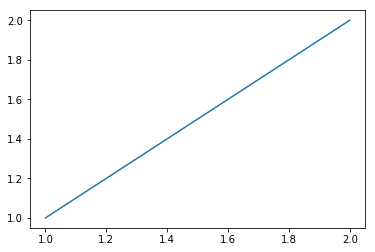

In [6]:
x = [1,2]
y = [1,2]
plt.plot(x,y)

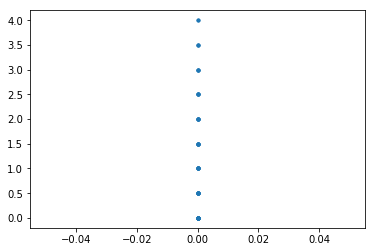

In [7]:
plt.plot(allCoordinates[:,0],allCoordinates[:,1],'.')